In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as mticker
from mpl_finance import candlestick2_ohlc
import sys

In [17]:
#directory = '/Users/filippo/Developer/tesi/results/hSBM/highlyvariable_7tissues'
directory = '/Users/filippo/Developer/tesi/gtex/hsbm/oversigma_10tissue'

In [18]:
L = 5

# topic size

In [14]:
def plot_topic_size(directory,l):
    df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topics.csv"%(directory,l))
    sizes = []
    for t in df_topics.columns:
        sizes.append(len(df_topics.loc[:,t].dropna()))
    bins = np.linspace(0.5, np.max(sizes)+0.5, int((np.max(sizes)+1)/(np.max(sizes)/5)))
    fig=plt.figure()
    plt.title("[%d topics, level: %d]"%(len(df_topics.columns),l))
    plt.hist(sizes, histtype='step', lw=2, bins=bins)
    plt.xlabel("topic size (# genes)", fontsize=16)
    plt.ylabel("# topic of that size", fontsize=16)
    plt.show()
    fig.savefig("%s/topic_size_level%d.png"%(directory,l))

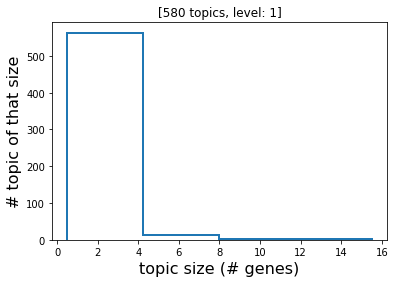

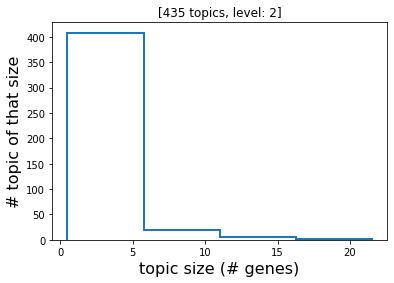

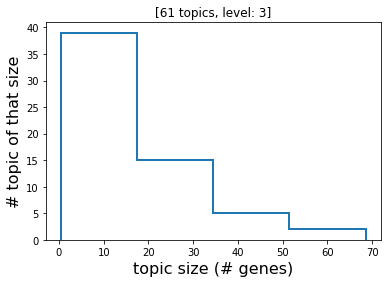

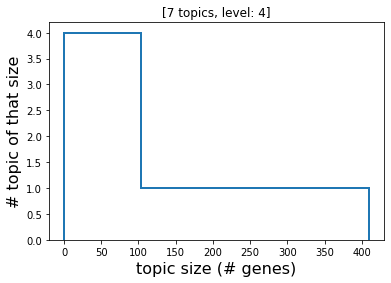

FileNotFoundError: [Errno 2] File b'/Users/filippo/Developer/tesi/gtex/hsbm/oversigma_7tissue/topsbm/topsbm_level_5_topics.csv' does not exist: b'/Users/filippo/Developer/tesi/gtex/hsbm/oversigma_7tissue/topsbm/topsbm_level_5_topics.csv'

In [15]:
for l in range(1,L+1):
    plot_topic_size(directory,l)

## Topic O

In [19]:
df_mv=pd.read_csv("%s/meanVariances.csv"%directory, index_col=[0])
#df_o = pd.read_csv("%s/O.dat"%directory, header=None)
#df_mv.insert(3, 'occurrence', df_o.values)
#df_mv['occurrence'] = df_mv['occurrence']
df_mv.head()

,mean,variance,type_of_gene
ENSG00000167578,1907.200,1731780.0,
ENSG00000078237,406.108,171432.0,
ENSG00000146083,4004.970,3980120.0,
ENSG00000158486,274.225,866071.0,
ENSG00000198242,12993.400,80215800.0,


In [20]:
def get_candles(directory, level, ax):
    df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topics.csv"%(directory,level))
    candles = {
        'open': [],
        'high': [],
        'low': [],
        'close':[],
        'size':[]
    }
    for topic in df_topics.columns:
        subarr = df_mv.loc[df_topics[topic].dropna(),:]['occurrence'].values
        avg = np.average(subarr)
        std = np.std(subarr)
        q=np.quantile(subarr,[0.25,0.75])
        candles['high'].append(np.min([1,avg+std]))
        candles['open'].append(np.min([q[1],1]))
        candles['close'].append(np.max([q[0],0]))
        candles['low'].append(np.max([0,avg-std]))
        candles['size'].append(len(subarr))
    ax.set_title("[level: %d]"%(l))
    ax.set_ylabel('$O_i$', fontsize=18)
    ax.set_xlim(-1,len(df_topics.columns))
    ax.set_xticks([i+1 for i in range(-1,len(df_topics.columns))])
    ax.set_xticklabels(["Topic %d"%(i+2) if ((i+2)%5==0 or i==-1) else '' for i in range(-1,len(df_topics.columns))],  rotation=60)
    return candles

In [ ]:
for l in range(0,L+1):
    fig = plt.figure(figsize=(15,8))
    ax = fig.subplots(1,2)
    candles = get_candles(directory,l,ax[0])
    candlestick2_ohlc(ax[0], candles['open'],candles['high'],candles['low'],candles['close'],width=0.6,colordown='b')
    ax[1].hist((np.array(candles['open'])+np.array(candles['close']))/2, weights=candles['size'], range=(-0.05,1.05), bins=10, histtype='step')
    plt.show()
    fig.savefig("%s/topic_Ocandles_level_%d.pdf"%(directory,l))

# Geneontology

In [21]:
from geneontology import get_ontology_df, ensg_to_symbol
from tableanalyser import get_symbol

In [27]:
l=3
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topics.csv"%(directory,l))

In [24]:
#import gseapy as gs
#gs.get_library_name()

In [28]:
back_sea=[]
for topic in df_topics.columns:
    for g in df_topics[topic].dropna().values:
        try:
            back_sea.append(get_symbol(g))
        except:
            print("error %s"%g)

In [31]:
for itopic,topic in enumerate(df_topics.columns):
    try:
        enriched_topic = pd.read_csv("%s/gsea_level_%d_topic%d(%d).csv"%(directory,l,itopic,len(symbols)), index_col=[0])
    except:
        symbols = ensg_to_symbol(df_topics.loc[:,topic].dropna().values)
        print(topic, " - " ,len(symbols))
        enriched_topic = get_ontology_df(symbols, background=back_sea).sort_values(by=['Adjusted P-value'], ascending=True)
        enriched_topic = enriched_topic.loc[enriched_topic.index.values[:20],:]
        enriched_topic.to_csv("%s/gsea_level_%d_topic%d(%d).csv"%(directory,l,itopic,len(symbols)))
    print(enriched_topic)

                                                   Term  Adjusted P-value  \
1762     GTEX-WFJO-0002-SM-3P61X_blood_male_30-39_years          0.000094   
1763   GTEX-TML8-0001-SM-3NMAF_blood_female_40-49_years          0.000094   
286   GTEX-X88G-0226-SM-4GIE4_adipose tissue_male_30...          0.000282   
287   GTEX-P4PQ-0226-SM-2S1NK_adipose tissue_male_60...          0.000454   
1764     GTEX-VUSH-0004-SM-3P61T_blood_male_30-39_years          0.000484   
288   GTEX-XUJ4-2826-SM-4BOQ2_blood vessel_female_60...          0.000603   
1765     GTEX-XBED-0003-SM-47JWP_blood_male_60-69_years          0.001222   
1766     GTEX-T5JC-0001-SM-3NMAK_blood_male_20-29_years          0.001453   
1767   GTEX-SN8G-0001-SM-3NM8L_blood_female_50-59_years          0.001453   
1768     GTEX-U8XE-0005-SM-3DB8I_blood_male_30-39_years          0.001453   
291   GTEX-QV31-1626-SM-2S1QC_blood vessel_male_30-3...          0.001940   
292   GTEX-XYKS-0426-SM-4BRW4_blood vessel_female_60...          0.001940   

FileNotFoundError: [Errno 2] File b'/Users/filippo/Developer/tesi/gtex/hsbm/oversigma_10tissue/gsea_level_3_topicTopic 2(12).csv' does not exist: b'/Users/filippo/Developer/tesi/gtex/hsbm/oversigma_10tissue/gsea_level_3_topicTopic 2(12).csv'

In [32]:
topic_pvalues = []
for topic in df_topics.columns:
    symbols = ensg_to_symbol(df_topics.loc[:,topic].dropna().values)
    try:
        enriched_topic = pd.read_csv("%s/gsea_level_%d_topic%s(%d).csv"%(directory,l,topic,len(symbols)))
        if len(enriched_topic.index) >0:
            p_val = np.sort(enriched_topic['Adjusted P-value'])[0]
            topic_pvalues.append(-np.log10(p_val))
    except:
        print("error", sys.exc_info()[0])

error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class 'FileNotFoundError'>
error <class '

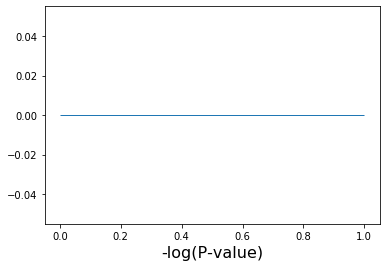

In [35]:
fig = plt.figure()
x = np.arange(1,1+len(topic_pvalues))
plt.hist(topic_pvalues, histtype='step')
plt.xlabel('-log(P-value)', fontsize=16)
#plt.ylim(0,0.055)
#plt.yscale('log')
fig.savefig("%s/pvaluescrosstopic(%d).png"%(directory,l))